In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def read_csv_strict(file_name='../input/g-research-crypto-forecasting/train.csv'):
    df = pd.read_csv(file_name)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df[df['datetime'] < '2021-06-13 00:00:00']
    return df
data_folder = "../input/g-research-crypto-forecasting/"
df = read_csv_strict()

df_asset_details = pd.read_csv(data_folder + 'asset_details.csv').sort_values("Asset_ID")
df_asset_details

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


In [3]:
!pip install talib-binary

ERROR: Could not find a version that satisfies the requirement talib-binary (from versions: none)
ERROR: No matching distribution found for talib-binary


In [4]:
def get_Xy(df_train, asset_id):
    df = df_train[df_train["Asset_ID"] == asset_id]
    
    # TODO: Try different features here!
    df_proc = get_features(df)
    df_proc['y'] = df['Target']
    df_proc = df_proc.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]

    return X, y

# Two new features from the competition tutorial
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
# # It works for rows to, so we can reutilize it.
# def get_features(df):
#     df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
#     return df_feat
# def get_features_1(df):
#     df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
#     df_feat['Upper_Shadow'] = upper_shadow(df_feat)
#     df_feat['Lower_Shadow'] = lower_shadow(df_feat)
#     return df_feat
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
#     df_feat['Upper_Shadow'] = upper_shadow(df_feat)
#     df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    df_feat["Close/Open"] = df_feat["Close"] / df_feat["Open"] 
    df_feat["Close-Open"] = df_feat["Close"] - df_feat["Open"] 
    df_feat["High-Low"] = df_feat["High"] - df_feat["Low"] 
    df_feat["High/Low"] = df_feat["High"] / df_feat["Low"]
    df_feat["Volume/Count"] = df_feat["Volume"] / (df_feat["Count"] + 1)
    return df_feat


In [5]:
Validation = True

Training model for Binance Coin     (ID=0 )
Training model for Bitcoin          (ID=1 )
Training model for Bitcoin Cash     (ID=2 )
Training model for Cardano          (ID=3 )
Training model for Dogecoin         (ID=4 )
Training model for EOS.IO           (ID=5 )
Training model for Ethereum         (ID=6 )
Training model for Ethereum Classic (ID=7 )
Training model for IOTA             (ID=8 )
Training model for Litecoin         (ID=9 )
Training model for Maker            (ID=10)
Training model for Monero           (ID=11)
Training model for Stellar          (ID=12)
Training model for TRON             (ID=13)
Binance Coin
0.08740009917450257
0.010513731765299583


<Figure size 432x288 with 0 Axes>

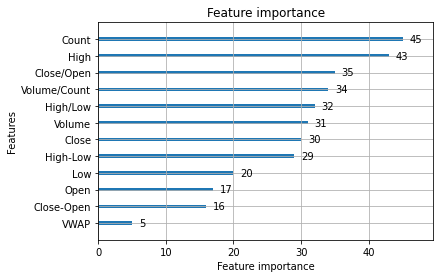

Bitcoin
0.09986316393956901
0.013407722867129417


<Figure size 432x288 with 0 Axes>

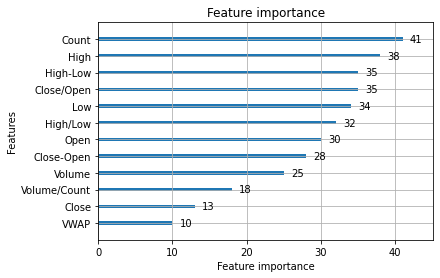

Bitcoin Cash
0.12534250610876124
0.008216981107755846


<Figure size 432x288 with 0 Axes>

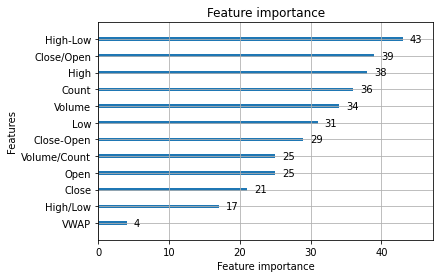

Cardano
0.06893795463582529
0.0026373097145459884


<Figure size 432x288 with 0 Axes>

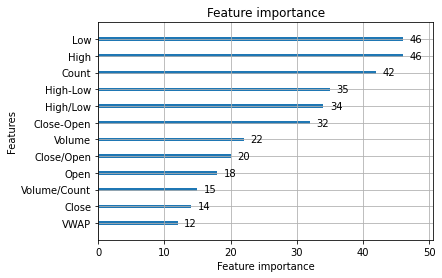

Dogecoin
0.13709300814992598
0.005793277678387222


<Figure size 432x288 with 0 Axes>

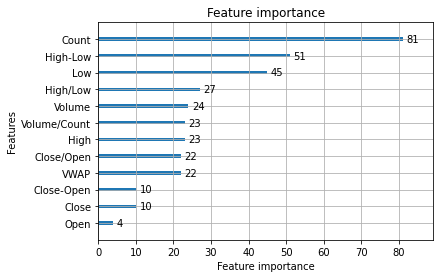

EOS.IO
0.07691965946511957
-0.001961597834880465


<Figure size 432x288 with 0 Axes>

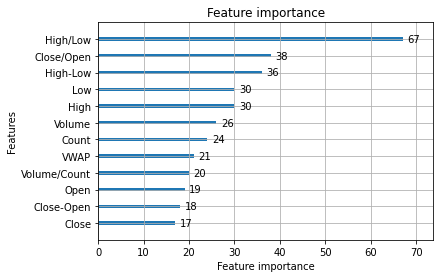

Ethereum
0.09805148666367311
0.010416602340032829


<Figure size 432x288 with 0 Axes>

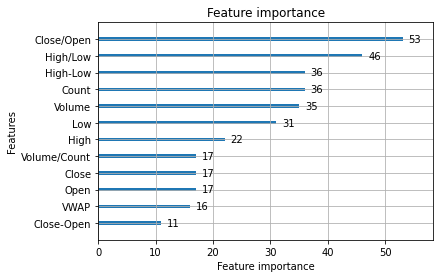

Ethereum Classic
0.08824059015510959
0.004374328523662835


<Figure size 432x288 with 0 Axes>

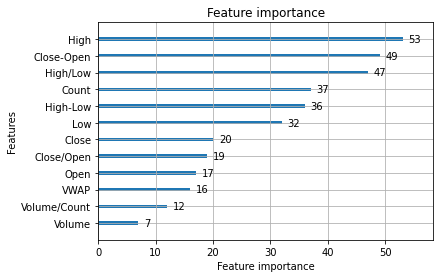

IOTA
0.09393516467126943
0.0056529846404637625


<Figure size 432x288 with 0 Axes>

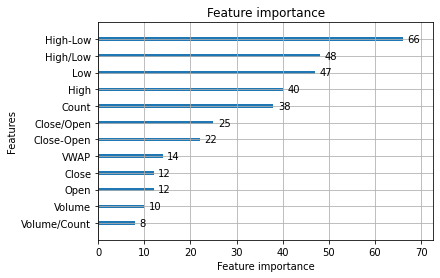

Litecoin
0.07734362331415501
-0.0021599055811046476


<Figure size 432x288 with 0 Axes>

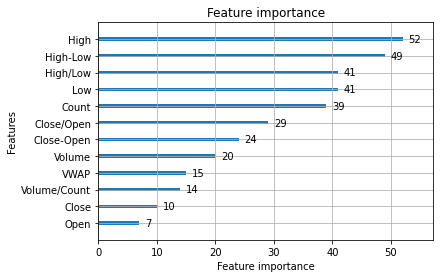

Maker
0.13975807062166787
0.008186668075213475


<Figure size 432x288 with 0 Axes>

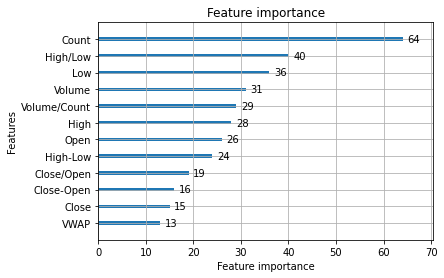

Monero
0.12632789903755345
0.014124962756246431


<Figure size 432x288 with 0 Axes>

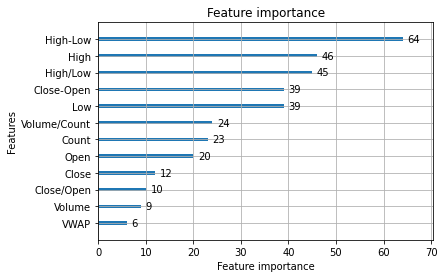

Stellar
0.07739180760820337
-0.005548872027146542


<Figure size 432x288 with 0 Axes>

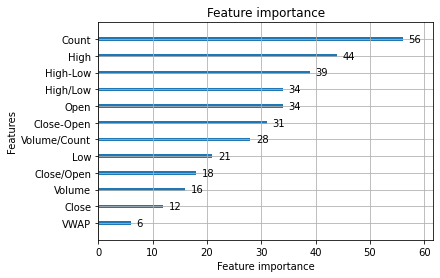

TRON
0.08030847490838362
0.007826143389019198


<Figure size 432x288 with 0 Axes>

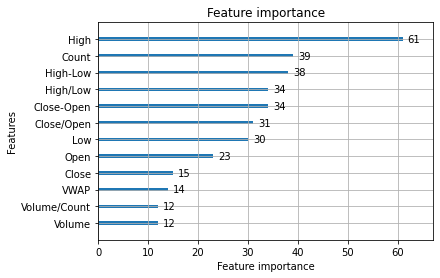

In [6]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
n_estimators = 50
num_leaves= 100
max_depth = 3

from sklearn.metrics import mean_squared_error
if Validation:
    Xs = {}
    ys = {}
    models = {}
    training_mse = {}
    validation_mse = {}
    training_corr = {}
    validation_corr = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
        X, y = get_Xy(df, asset_id)    
        X_train, y_train = X[:int(len(X)*0.75)], y[:int(len(X)*0.75)]
        X_test, y_test = X[int(len(X)*0.75):], y[int(len(X)*0.75):]
        X_train = get_features(X_train)
        X_test = get_features(X_test)
        model = LGBMRegressor(num_leaves=num_leaves,max_depth=max_depth , n_estimators=n_estimators)
        model.fit(X_train, y_train)
        models[asset_id] = model
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        training_mse[asset_id] = mean_squared_error(y_train_pred, y_train)
        validation_mse[asset_id] = mean_squared_error(y_test_pred, y_test)
        training_corr[asset_id] = np.corrcoef(y_train_pred, y_train)[0][1]
        validation_corr[asset_id] = np.corrcoef(y_test_pred, y_test)[0][1]
    
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        print(asset_name)
#         print(training_mse[asset_id])
        print(training_corr[asset_id])
#         print(validation_mse[asset_id])
        print(validation_corr[asset_id])
        plt.figure()
        lgb.plot_importance(models[asset_id])
        plt.show()
        
    
    
    
    



In [7]:
n_estimators = 50
num_leaves= 100
max_depth = 3
from lightgbm import LGBMRegressor
Xs = {}
ys = {}
models = {}
for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    X, y = get_Xy(df, asset_id)    
    Xs[asset_id], ys[asset_id] = X, y
    X = get_features(X)
    model = LGBMRegressor(num_leaves=num_leaves,max_depth=max_depth , n_estimators=n_estimators)
    model.fit(X, y)
    models[asset_id] = model




Training model for Binance Coin     (ID=0 )
Training model for Bitcoin          (ID=1 )
Training model for Bitcoin Cash     (ID=2 )
Training model for Cardano          (ID=3 )
Training model for Dogecoin         (ID=4 )
Training model for EOS.IO           (ID=5 )
Training model for Ethereum         (ID=6 )
Training model for Ethereum Classic (ID=7 )
Training model for IOTA             (ID=8 )
Training model for Litecoin         (ID=9 )
Training model for Maker            (ID=10)
Training model for Monero           (ID=11)
Training model for Stellar          (ID=12)
Training model for TRON             (ID=13)


In [8]:
import gresearch_crypto

env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        
        model = models[row['Asset_ID']]
        x_test = get_features(row)
        y_pred = model.predict([x_test])[0]
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
        # Print just one sample row to get a feeling of what it looks like
        if i == 0 and j == 0:
            display(x_test)
    # Display the first prediction dataframe
    if i == 0:
        display(df_pred)
    # Send submissions
    env.predict(df_pred)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


Count             1201.000000
Open                 1.478556
High                 1.486030
Low                  1.478000
Close                1.483681
Volume          654799.561103
VWAP                 1.481439
Close/Open           1.003467
Close-Open           0.005126
High-Low             0.008030
High/Low             1.005433
Volume/Count       544.758370
Name: 0, dtype: float64

,row_id,Target
0,0,-0.000226
1,1,0.000015
2,2,0.000027
3,3,-0.000024
4,4,0.000007
5,5,-0.000030
6,6,0.000275
7,7,-0.000041
8,8,-0.000047
9,9,-0.000095
